In [1]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

In [42]:
from smaller_model import UNet
import PIL.Image as Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

transforms = T.Compose([
    T.ToTensor(),
    T.CenterCrop(224)
])

model = UNet()

state_dict = torch.load('./checkpoints/model_8.pth')
model.load_state_dict(state_dict)

img = Image.open('/home/danny/datasets/ILSVRC/Data/train/n01440764/n01440764_10026.JPEG').convert('L')
img = np.array(img)
std = np.random.uniform(0, 1)
noise = np.random.normal(0, std, size=img.shape)

noisy_img = transforms(img + noise)
noisy_img2 = transforms(img.copy() + noise)

example = torch.cat((noisy_img, noisy_img2), dim=0).to(torch.float)
example.shape

torch.Size([2, 224, 224])

In [52]:
pred = model(example.unsqueeze(dim=0)).squeeze(dim=0).detach().numpy()
cropped_image = transforms(img).squeeze(0).detach().numpy()
print(pred.shape)

(2, 224, 224)


38.82542610168457


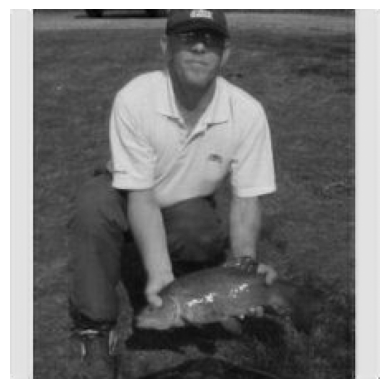

In [58]:
plot_img(pred[0])
print(calculate_psnr(pred, cropped_image))

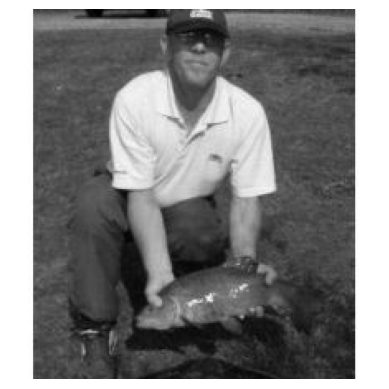

In [41]:
plot_img(noisy_img.permute((1, 2, 0)))

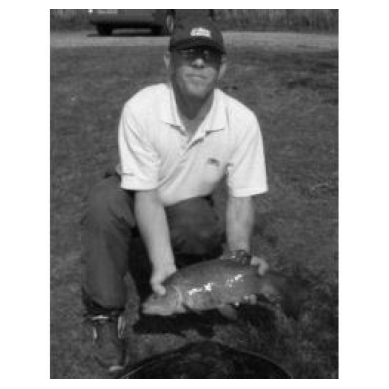

In [15]:
plot_img(img)

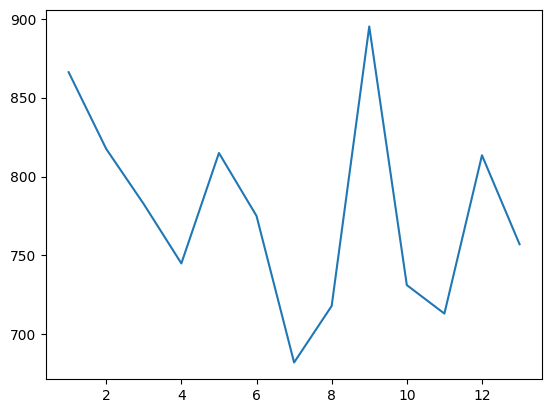

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import re



y = [866.1317749023438, 817.4989624023438, 782.4913940429688, 744.9010620117188, 814.9049682617188, 775.0090942382812, 682.1031494140625, 717.9232788085938, 895.1112060546875, 731.15185546875, 713.0975341796875, 813.4630737304688, 757.0565795898438]
x = [i + 1 for i in range(len(y))]

plt.plot(x, y)
plt.show()
x

In [6]:
from dataset import CustomDataset

img_list_path = 'data/imagenet_files_bluestone.txt'
dataset = CustomDataset(img_list_file=img_list_path, device='cpu', sub_set=50)

In [24]:
import matplotlib.pyplot as plt

def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

def plot_img_grid(imgs, titles):
    fig, axs = plt.subplots(len(imgs), 4, figsize=(10, 10))
    for i in range(len(imgs)):
        axs[i, 0].imshow(imgs[i][0], cmap='gray')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(imgs[i][1], cmap='gray')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(imgs[i][2], cmap='gray')
        axs[i, 2].axis('off')

        axs[i, 3].imshow(imgs[i][3], cmap='gray')
        axs[i, 3].axis('off')

    # tighten space between plots
    plt.tight_layout()
    axs[0, 0].set_title(titles[0])
    axs[0, 1].set_title(titles[1])
    axs[0, 2].set_title(titles[2])
    axs[0, 3].set_title(titles[3])
    plt.show()


# src_pair, target_pair = next(iter(dataset))

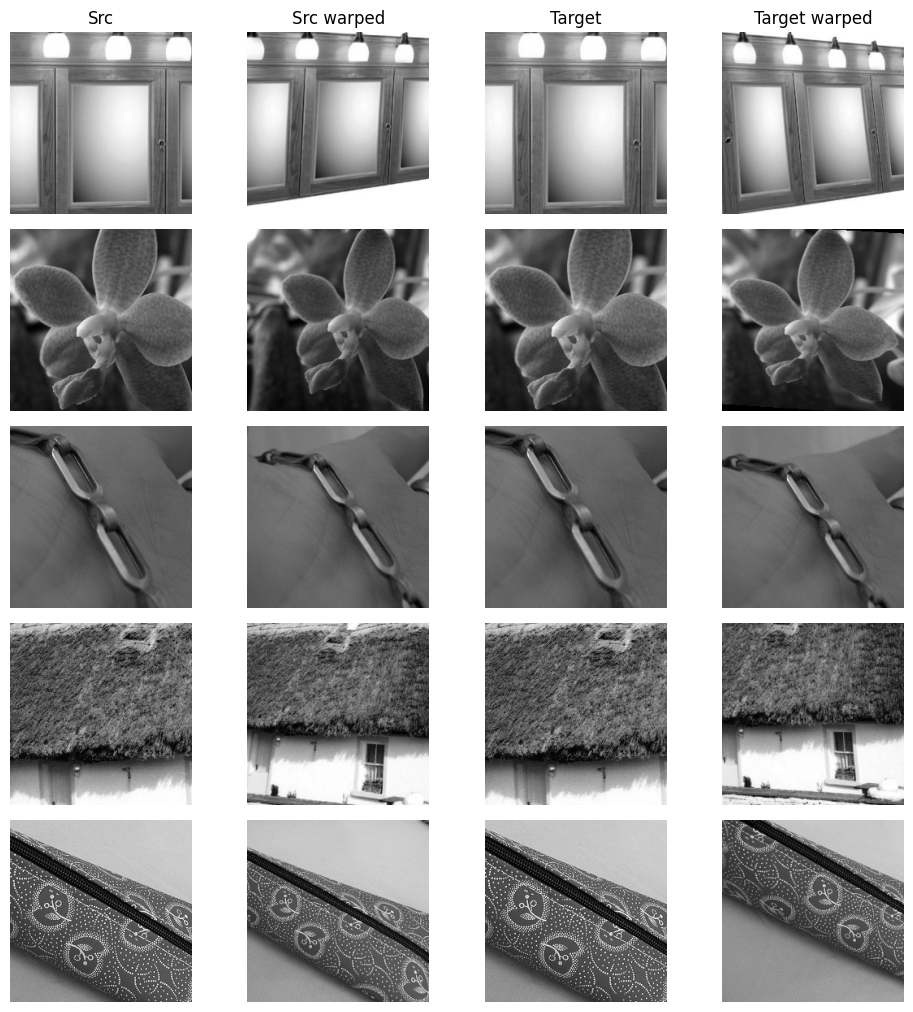

In [8]:
import numpy as np
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

images = []
i = 0
for src_pair, target_pair in dataloader:
    src_pair, target_pair = dataset[i]
    src, src_warped = src_pair
    target, target_warped = target_pair

    images.append([])
    images[i].extend([src, src_warped, target, target_warped])
    i += 1
    if i == 5:
        break

plot_img_grid(np.array(images))

In [3]:
from dataset import CustomDataset
from smaller_model import UNet
from eval import calculate_psnr
import torch


def eval_model(model, dataset):
    model.eval()
    psnr_warped = 0
    psnr_no_warp = 0

    img_results = []

    for i, (noisy, gt) in enumerate(dataset):
        pred = model(noisy.unsqueeze(dim=0)).squeeze(dim=0)

        pred_normal = pred[0].detach().cpu().numpy()
        pred_warped = pred[1].detach().cpu().numpy()

        gt_warped = gt[1].detach().cpu().numpy()
        gt_normal = gt[0].detach().cpu().numpy()

        psnr_no_warp += calculate_psnr(gt_normal, pred_normal)
        psnr_warped += calculate_psnr(gt_warped, pred_warped)
        noisy = noisy.detach().cpu().numpy()

        img_results.append([noisy[0], pred_normal, gt_normal, noisy[1], pred_warped, gt_warped])

    psnr_no_warp /= len(dataset)
    psnr_warped /= len(dataset)

    return psnr_no_warp, psnr_warped, img_results

img_list_path = 'data/val_bluestone.txt'
val_set = CustomDataset(img_list_file=img_list_path, device='cuda', is_val=True, sub_set=15, rand_sub=False, stereo=True)

model = UNet(2)
state_dict = torch.load('./checkpoints/model_16.pth')
model.load_state_dict(state_dict)

rand_model = UNet(2)

model = model.to('cuda')
rand_model = rand_model.to('cuda')

psnr_no_warp, psnr_warped, img_results = eval_model(model, val_set)
# psnr_no_warp_rand, psnr_warped_rand, img_results_rand = eval_model(rand_model, val_set)

-43.08776458104452


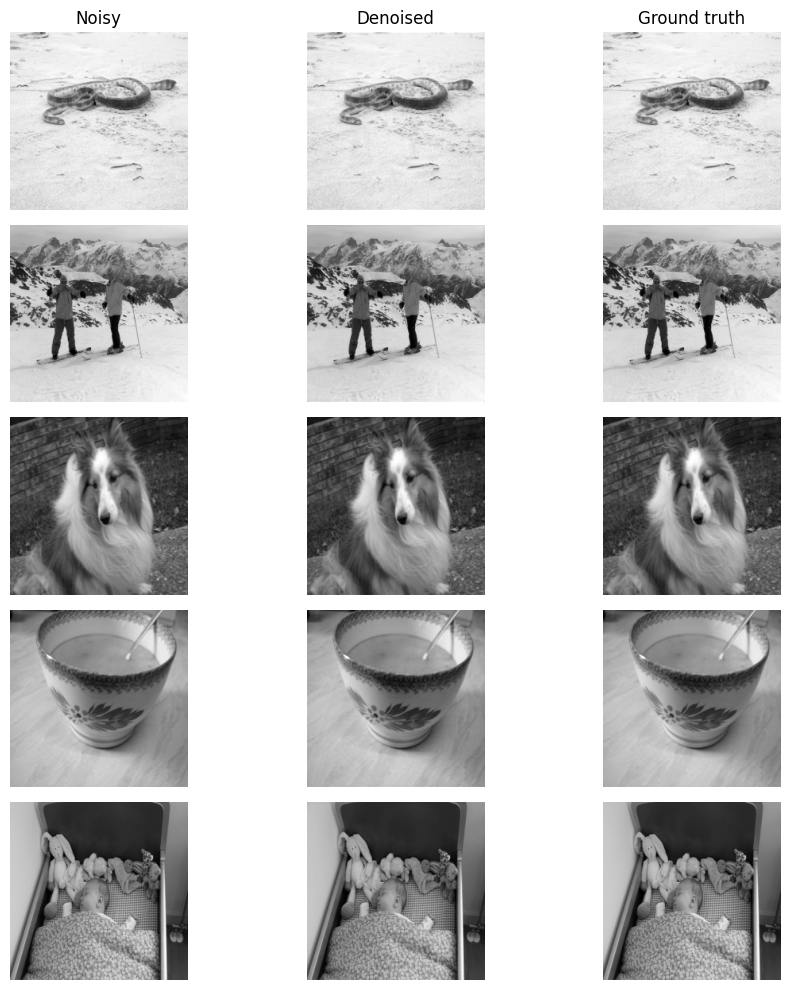

In [4]:
import matplotlib.pyplot as plt

combined_ours = []
combined_random = []
for i in range(len(img_results)):
    combined_ours.extend([
        img_results[i][0], # noisy normal
        img_results[i][1], # pred normal
        img_results[i][2], # Ground truth
        # img_results[i][4], # pred warped
        ])
    # combined_random.extend([
    #     img_results_rand[i][0], # noisy normal
    #     img_results_rand[i][1], # pred normal
    #     img_results_rand[i][3], # noisy warped
    #     img_results_rand[i][4], # pred warped
    # ])

titles = ['Noisy', 'Denoised', 'Ground truth']

def plot_img_grid(imgs, titles, n_row, n_col):
    fig, axs = plt.subplots(n_row, n_col, figsize=(10, 10))
    for i in range(n_row):
        for j in range(n_col):
            axs[i, j].imshow(imgs[i * n_col + j], cmap='gray')
            axs[i, j].axis('off')
        
            axs[0, j].set_title(titles[j])

    # tighten space between plots
    plt.tight_layout()
    plt.show()

print(psnr_no_warp)
plot_img_grid(combined_ours, titles, 5, 3)
# plot_img_grid(combined_random, titles, 5, 4)
    